This Jupyter Notebook include some basic data analysis and visualizations of WHO data on COVID-19 which caused a global pandemic in 2020

contact: 🐦twitter@smirshekari

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.ticker as mtick
from random import sample 
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Import Data

In [2]:
# data Downloaded from: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases on 03/22/2020
corona_confirmed = pd.read_csv('/home/smirs/Downloads/time_series-ncov-Confirmed.csv', skiprows=[1])
corona_deaths    = pd.read_csv('/home/smirs/Downloads/time_series-ncov-Deaths.csv', skiprows=[1])
corona_recovered = pd.read_csv('/home/smirs/Downloads/time_series-ncov-Recovered.csv', skiprows=[1])

# Deta Cleaning/Reshaping

In [3]:
# Tag datasets before combining them to one
corona_confirmed['Key'] = '#confirmed'
corona_deaths['Key'] = '#dead'
corona_recovered['Key'] = '#recovered'

In [4]:
# make a target list of countries for plotting
country_list = ['Italy', 'Korea, South', 'Germany', 'US', 'Spain', 'France', 'Switzerland', 'China', 'Iran', 'United Kingdom']

# Concatinating data
data_frames = pd.concat([corona_confirmed, corona_deaths, corona_recovered])
# Limit data from the countries from the target country list
data_frames = data_frames.loc[data_frames['Country/Region'].isin(country_list)]

# Reshaping data
data_frames = data_frames.loc[:,['Country/Region', 'Date', 'Value', 'Key']]
# converting the column 'Date' to datetime64 type
data_frames['Date'] = data_frames['Date'].astype('datetime64[ns]') 
# Reshaping data by grouping by country within a date for each key and reindexing
data_frames = data_frames.groupby(['Country/Region', 'Date', 'Key']).sum().reset_index()

In [5]:
# pivoting data
data_frames = pd.pivot_table(data_frames, values='Value', index=['Country/Region', 'Date'], columns=['Key'], aggfunc=np.sum).reset_index() 

In [6]:
# take a look at our cleaned & reshaped dataset
data_frames

Key,Country/Region,Date,#confirmed,#dead,#recovered
0,China,2020-01-22,548,17,28
1,China,2020-01-23,643,18,30
2,China,2020-01-24,920,26,36
3,China,2020-01-25,1406,42,39
4,China,2020-01-26,2075,56,49
...,...,...,...,...,...
605,United Kingdom,2020-03-18,2642,72,67
606,United Kingdom,2020-03-19,2716,138,67
607,United Kingdom,2020-03-20,4014,178,67
608,United Kingdom,2020-03-21,5067,234,67


# Creating New Insightful Features

In [7]:
def get_yesterday_confirmed(today, mycountry):
    '''
    This functions takes today date and a country as inputs and returns the value of confirmed-cases from a day before
    '''
    DD = datetime.timedelta(days=1)
    yesterday = today - DD
    yesterday_str = yesterday.strftime("%Y-%m-%d")
    
    try:
        res = data_frames.loc[(data_frames['Country/Region'] == mycountry) & (data_frames['Date']==yesterday_str)]['#confirmed'].reset_index()['#confirmed'][0]
    except:
        res = 0
    return res

In [8]:
def get_yesterday_dead(today, mycountry):
    '''
    This functions takes today date and a country as inputs and returns the value of dead-cases from a day before
    '''
    DD = datetime.timedelta(days=1)
    yesterday = today - DD
    yesterday_str = yesterday.strftime("%Y-%m-%d")
    
    try:
        res = data_frames.loc[(data_frames['Country/Region'] == mycountry) & (data_frames['Date']==yesterday_str)]['#dead'].reset_index()['#dead'][0]
    except:
        res = 0
    return res

In [9]:
def get_yesterday_recovered(today, mycountry):
    '''
    This functions takes today date and a country as inouts and returns the value of recovered-cases from the day before
    '''
    DD = datetime.timedelta(days=1)
    yesterday = today - DD
    yesterday_str = yesterday.strftime("%Y-%m-%d")
    
    try:
        res = data_frames.loc[(data_frames['Country/Region'] == mycountry) & (data_frames['Date']==yesterday_str)]['#recovered'].reset_index()['#recovered'][0]
    except:
        res = 0
    return res

In [10]:
# Adding new columns to include yesterday values
data_frames['#yesterday_confirmed'] = data_frames.apply(lambda x: get_yesterday_confirmed(x['Date'], x['Country/Region']), axis=1)
data_frames['#yesterday_dead'] = data_frames.apply(lambda x: get_yesterday_dead(x['Date'], x['Country/Region']), axis=1)
data_frames['#yesterday_recovered'] = data_frames.apply(lambda x: get_yesterday_recovered(x['Date'], x['Country/Region']), axis=1)

# Adding new columns to include daily new values
data_frames['#new_confirmed'] = data_frames['#confirmed'] - data_frames['#yesterday_confirmed']
data_frames['#new_dead'] = data_frames['#dead'] - data_frames['#yesterday_dead']
data_frames['#new_recovered'] = data_frames['#recovered'] - data_frames['#yesterday_recovered']

In [11]:
# Adding new columns to include other insightful values
data_frames['dead_by_confirmed'] = data_frames['#dead']/data_frames['#confirmed']*100
data_frames['recovered_by_confirmed'] = data_frames['#recovered']/data_frames['#confirmed']*100
data_frames['confirmed_minus_recovered&dead'] = data_frames['#confirmed'] - data_frames['#recovered'] - data_frames['#dead']

In [12]:
df = pd.DataFrame(columns=data_frames.columns)
for country in country_list:
    sub_df = data_frames.loc[(data_frames['Country/Region']==country) & (data_frames['#dead']>= 10)].reset_index(drop=True)
    #sub_df['Key'] = sub_df.index
    #display(sub_df)
    df = df.append(sub_df, sort=True)
    
df['days_after_threshold'] = df.index    
data_frames_indexed = df
threshold_str = 'Days After 10th Death'

# Plotting

In [13]:
# setting seaborn and marker character
sns.set()
marker_pool = ('h')

## Mortality Rate [excluding/Incuding Iran]

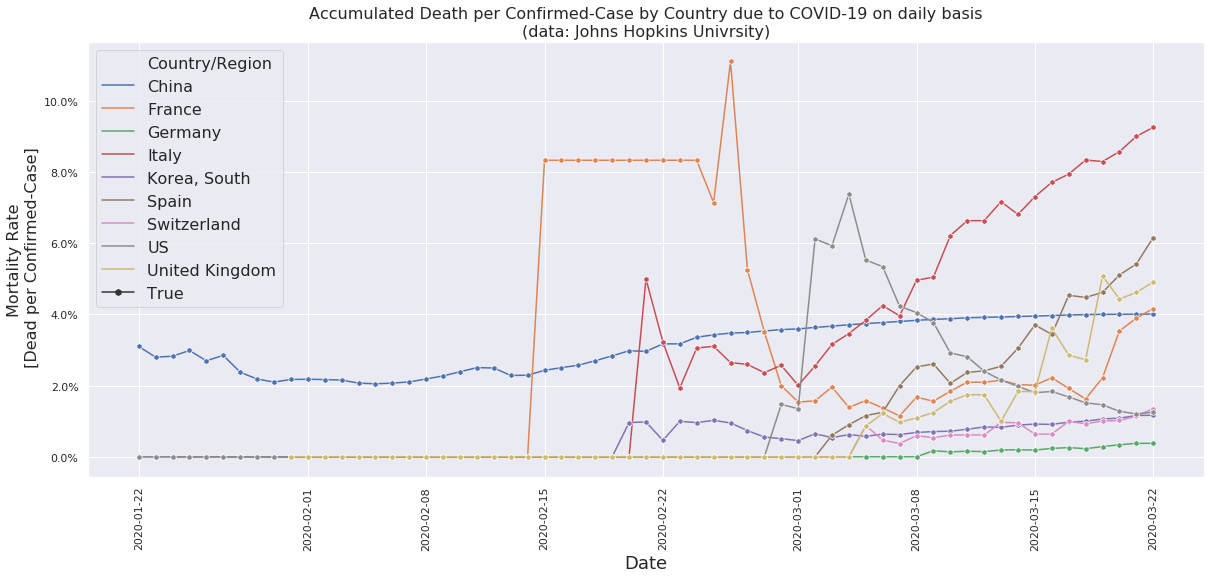

In [14]:
df = data_frames.loc[data_frames['Date']>'2020-01-01']
df_noiran = df.loc[df['Country/Region'] != 'Iran']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)

plt.title('Accumulated Death per Confirmed-Case by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.lineplot(x='Date', y='dead_by_confirmed', hue='Country/Region', style=True, markers=marker_pool, data=df_noiran)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mortality Rate\n [Dead per Confirmed-Case]', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
display(plot)

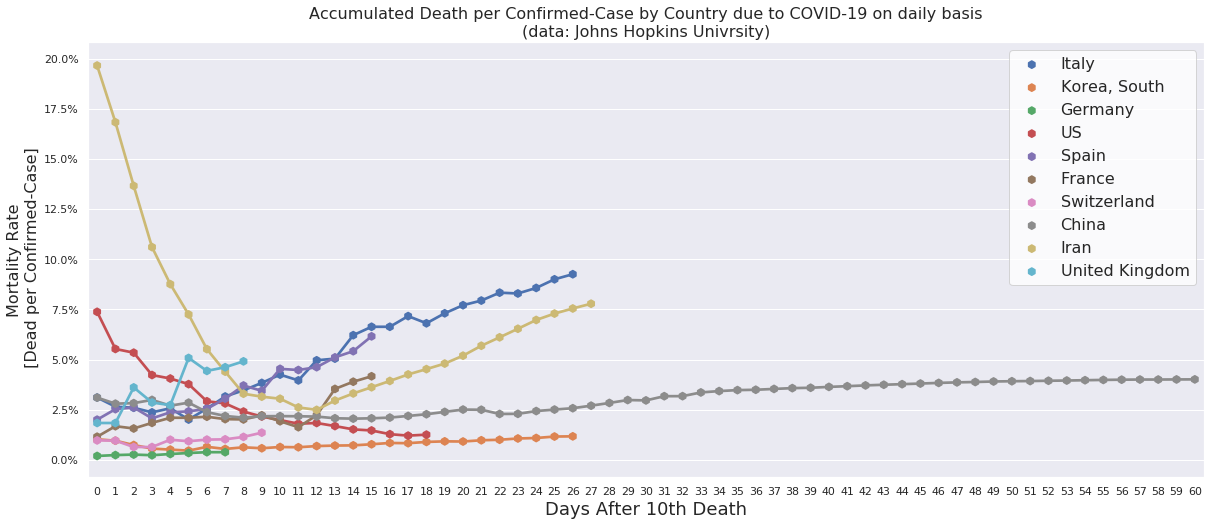

In [15]:
df = data_frames_indexed.loc[data_frames_indexed['Date']>'2020-01-01']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('Accumulated Death per Confirmed-Case by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='dead_by_confirmed', hue='Country/Region', style=True, markers=marker_pool, data=df)
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('Mortality Rate\n [Dead per Confirmed-Case]', fontsize=16)
plot.legend(loc=1, prop={'size': 16})
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
display(plot)

Looking at the #dead-cases divided by #confirmed-cases since 10th death in each country:
- US is dropping (maybe b/c of increasing #tests like Iran)
- US, Germany, S Korea, and Switzerlan have kept it down
- Italy and Spain are surging, Iran and France are following

## Some Notes
Assuming the true mortality rate of COVID-19 is fairly constant among human communities and corona tests are the same across the globe, this plot suggest:

* There can be a similar pattern across the curves for which 3 phases can be identified in each curve:

   (1) **Waking-Up Phase:** in which the curve starts. In this phase testing is begun and the first death-case has been reported. Different countries have different start dates as you can see.
   
   (2) **Learning Phase:** in which the curve climbs up. In this phase the true number of infected peaple is still not completely known and the number of tests is growing to learn more about the true mortality rate. During this phase, most of the early admitted cases have been in critical conditions and therefore more confirmed-cases has led to death (and therefore higher morality rate).
   
   (3) **Stability Phase:** in which the curve falls down and ultimately would converge to a constant value (i.e. the true morality rate of COVID-19). During this phase, over time, we have gradually increased the number of tests substantially and therefore less confirmed-cases lead to death. As we go towards the end of this phase, we obtain enough test data such that the number of death-cases divided by the number of confirmed-cases is constant.

* Looking at **Waking-Up** phase:

    (1) China has started way before the other countries.
    
    (2) Most countries have started from late February to early March. 

* Looking at **Learning** and **Stability** phases:

    (1) When exactly China learned it first?!
    
    (2) South Korea and Switzerland have completed the learning phase pretty quickly right from the beginning! Which requires massive testing from day 1...
    
    (3) USA also has completed the learning phase (reached the pick), but it took some time
    
    (4) USA, South Korea, and Switzerland's curves all converge to the same mortality rate value of ~1% 
    
    (5) China's rate is significantly different at about 4%
    
    (6) Francec seem to be learning a new rate which has recently become closer to China's average mortality rate
    
    (7) Germany, for some reason, maintains a continous lower mortality rate since day 1
    
    (8) Italy, Iran, Spain, and France are still learning and have not reached the stability phase just yet! (meaning still need more tests to be done) This might be because of the fact that these countries have fallen behind the curve and health system is overloaded. Therefore they have not a good idea of how much of their population are actually infected because they are fully busy mostly with critical cases (not a fair statistical sample).

## Current Under-Medicare Population by Country

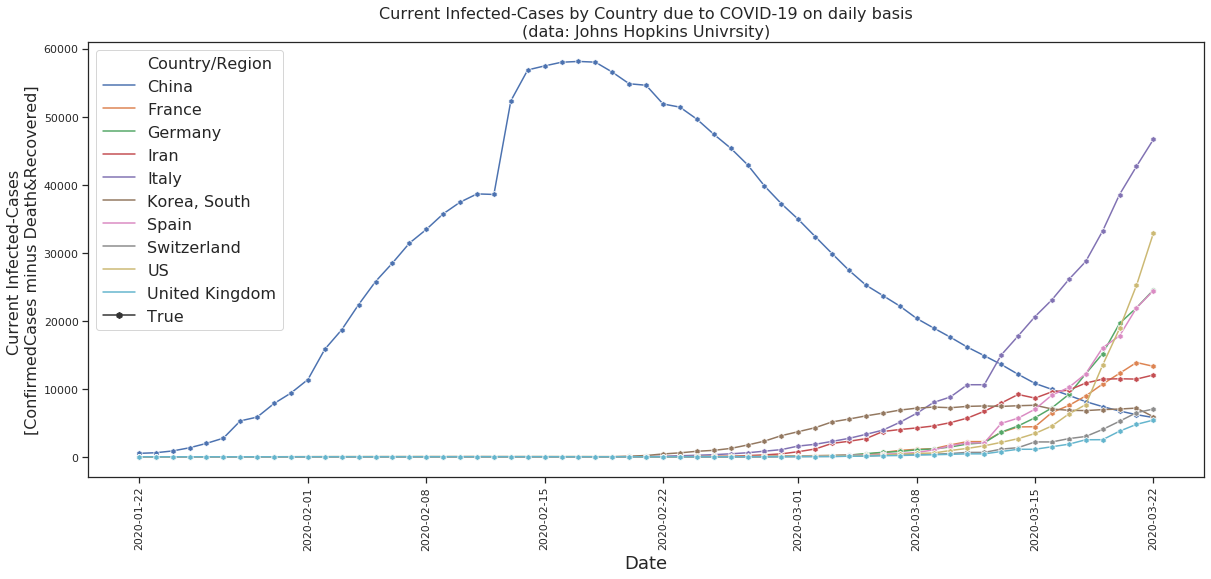

In [16]:
df = data_frames.loc[data_frames['Date']>'2020-01-01']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('Current Infected-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.lineplot(x='Date', y='confirmed_minus_recovered&dead', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Current Infected-Cases \n[ConfirmedCases minus Death&Recovered]', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

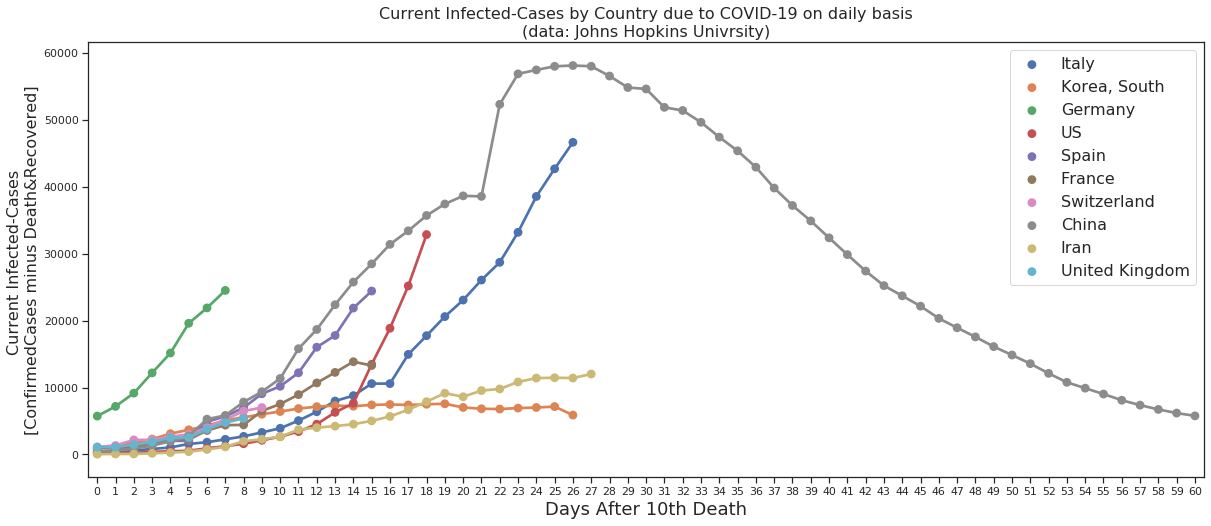

In [17]:
df = data_frames_indexed

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('Current Infected-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='confirmed_minus_recovered&dead', hue='Country/Region', data=df)
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('Current Infected-Cases \n[ConfirmedCases minus Death&Recovered]', fontsize=16)
plot.legend(loc=1, prop={'size': 16})
display(plot)

Looking at the currently under teatment population (i.e. total confirmed cases minus death and recovered) since 10th death in each country:
- It has taken China a month to reach the pick
- Germany has started off well above others (massive tests)
- US is learning super fast!
- Iran, Korea, and possible France are not overloading their healthcare system


## Daily New Confirmed Cases by Country

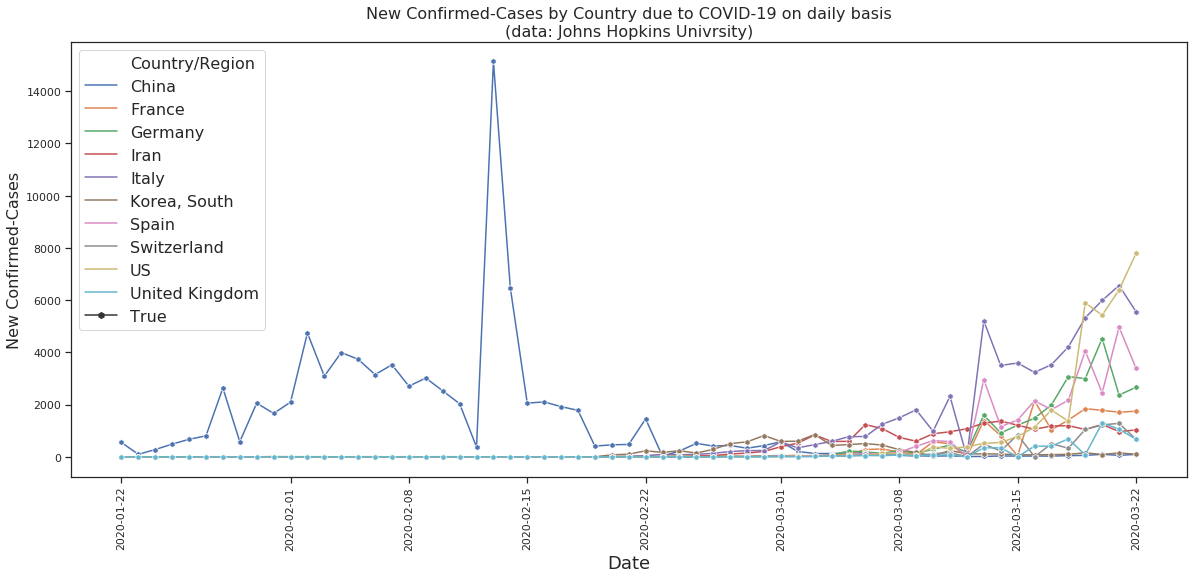

In [18]:
df = data_frames.loc[data_frames['Date']>'2020-01-01']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('New Confirmed-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.lineplot(x='Date', y='#new_confirmed', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('New Confirmed-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

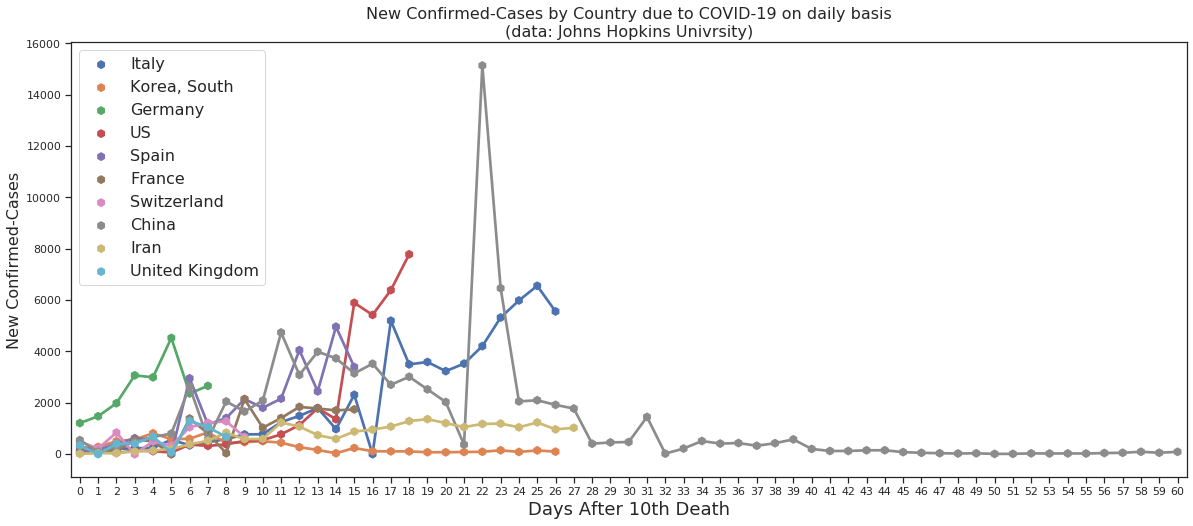

In [19]:
df = data_frames_indexed

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('New Confirmed-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='#new_confirmed', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('New Confirmed-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

## Daily New Dead Cases by Country

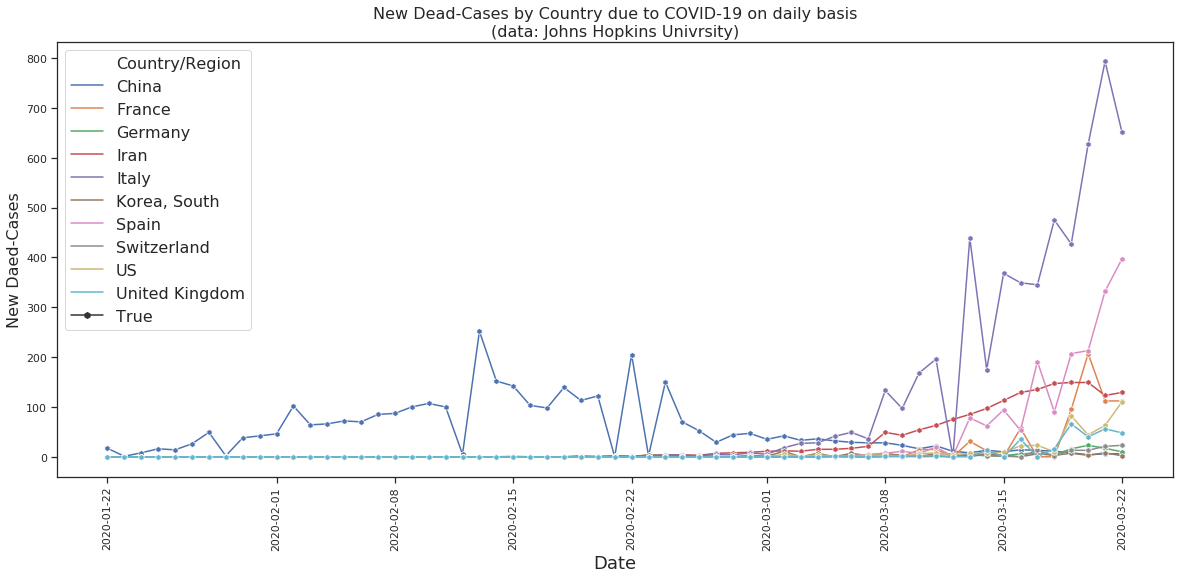

In [20]:
df = data_frames.loc[data_frames['Date']>'2020-01-01']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('New Dead-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.lineplot(x='Date', y='#new_dead', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('New Daed-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

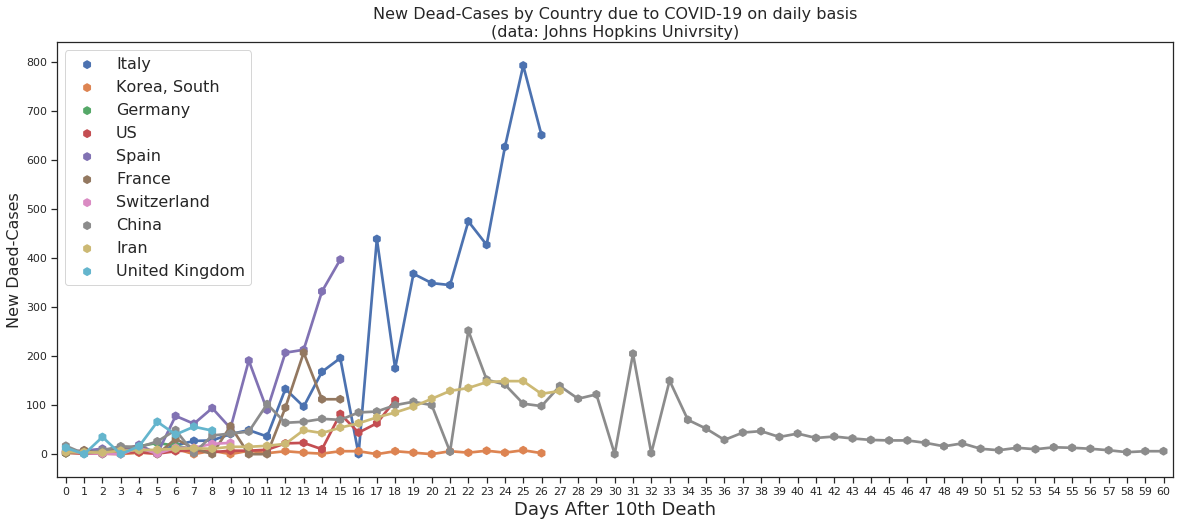

In [21]:
df = data_frames_indexed

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('New Dead-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='#new_dead', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('New Daed-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

## Daily New Recovered Cases by Country

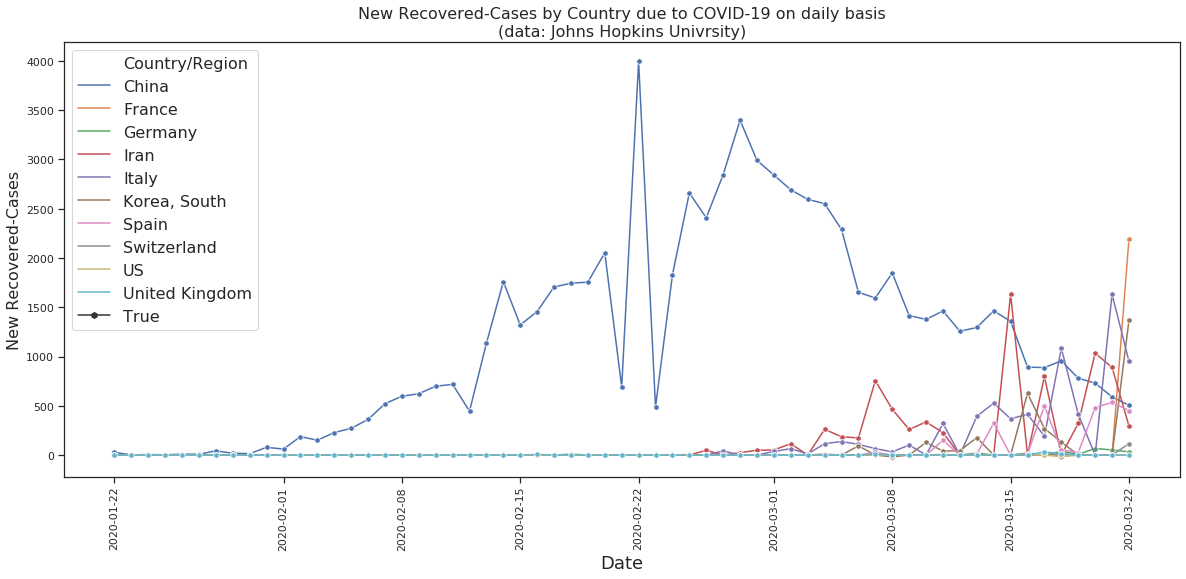

In [22]:
df = data_frames.loc[data_frames['Date']>'2020-01-01']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('New Recovered-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.lineplot(x='Date', y='#new_recovered', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('New Recovered-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

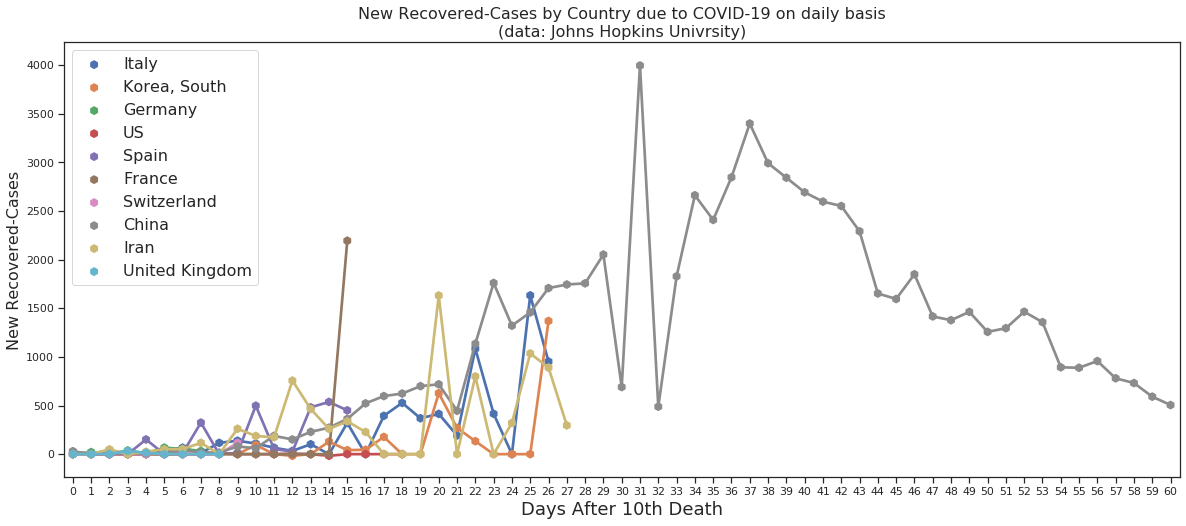

In [23]:
df = data_frames_indexed

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('New Recovered-Cases by Country due to COVID-19 on daily basis\n(data: Johns Hopkins Univrsity)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='#new_recovered', hue='Country/Region', style=True, markers=marker_pool, dashes=False, data=df)
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('New Recovered-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

## Recovered per Confirmed Cases by Country

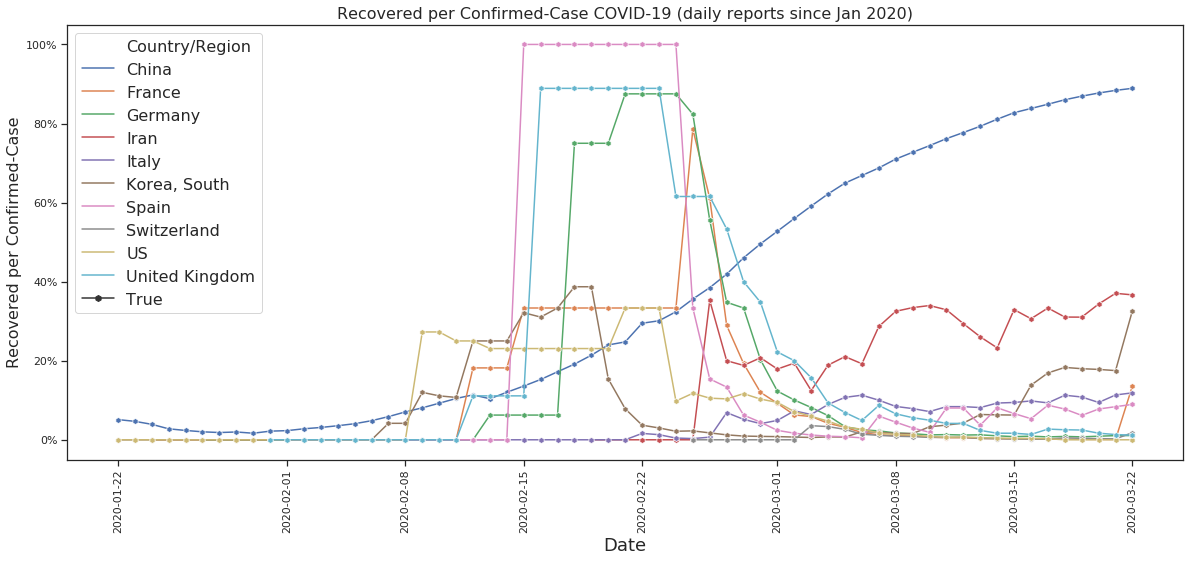

In [24]:
df = data_frames.loc[data_frames['Date']>'2020-01-15']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('Recovered per Confirmed-Case COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.lineplot(x='Date', y='recovered_by_confirmed', hue='Country/Region', style=True, markers=marker_pool, data=df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Recovered per Confirmed-Case', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
display(plot)

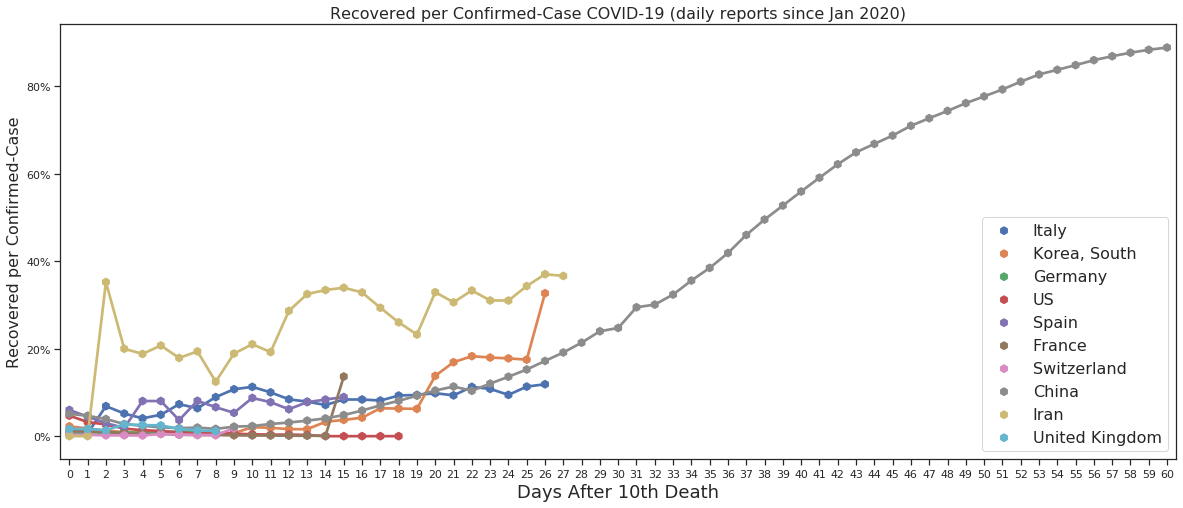

In [25]:
df = data_frames_indexed

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.title('Recovered per Confirmed-Case COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='recovered_by_confirmed', hue='Country/Region', style=True, markers=marker_pool, data=df)
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('Recovered per Confirmed-Case', fontsize=16)
plot.legend(loc=4, prop={'size': 16})
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
display(plot)

Looking at the number of recovered cases per confimed cases since 10th death in each country:
- Iran shows almost twice recovery rate
- US has not recovered much yet
- S Korea started massive recoveries recently

## Accumulated Confirmed Cases by Country

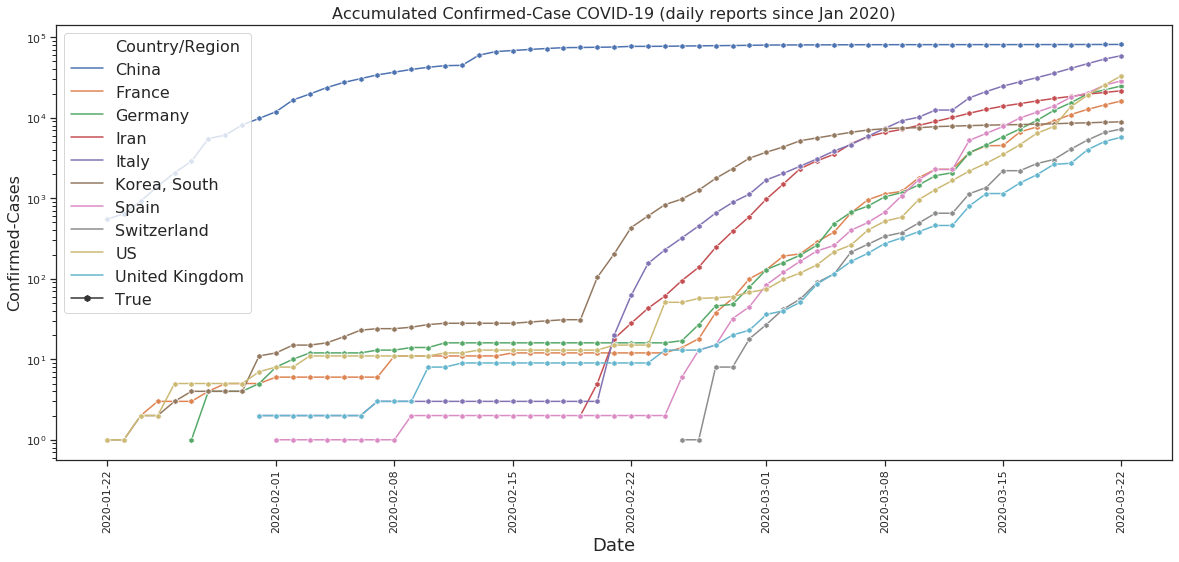

In [26]:
df = data_frames.loc[data_frames['Date']>'2020-01-15']
df = df.dropna()
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)

plt.title('Accumulated Confirmed-Case COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.lineplot(x='Date', y='#confirmed', hue='Country/Region', style=True, markers=marker_pool, data=df)
plot.set_yscale('log')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Confirmed-Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

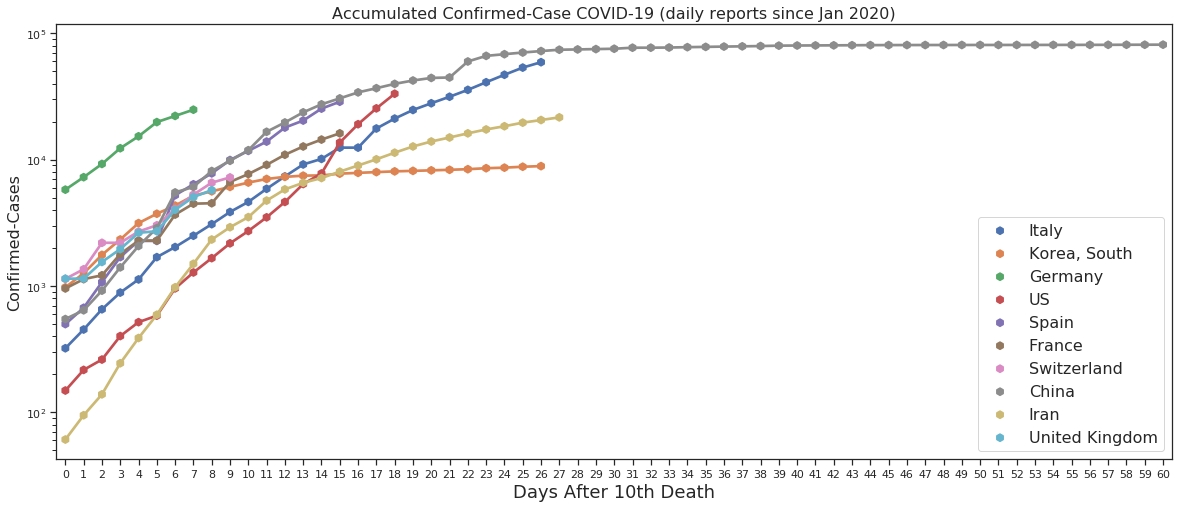

In [27]:
df = data_frames_indexed
df = df.dropna()
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)

plt.title('Accumulated Confirmed-Case COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='#confirmed', hue='Country/Region', style=True, markers=marker_pool, data=df)
plot.set_yscale('log')

plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('Confirmed-Cases', fontsize=16)
plot.legend(loc=4, prop={'size': 16})
display(plot)

## Accumulated Dead Cases by Country

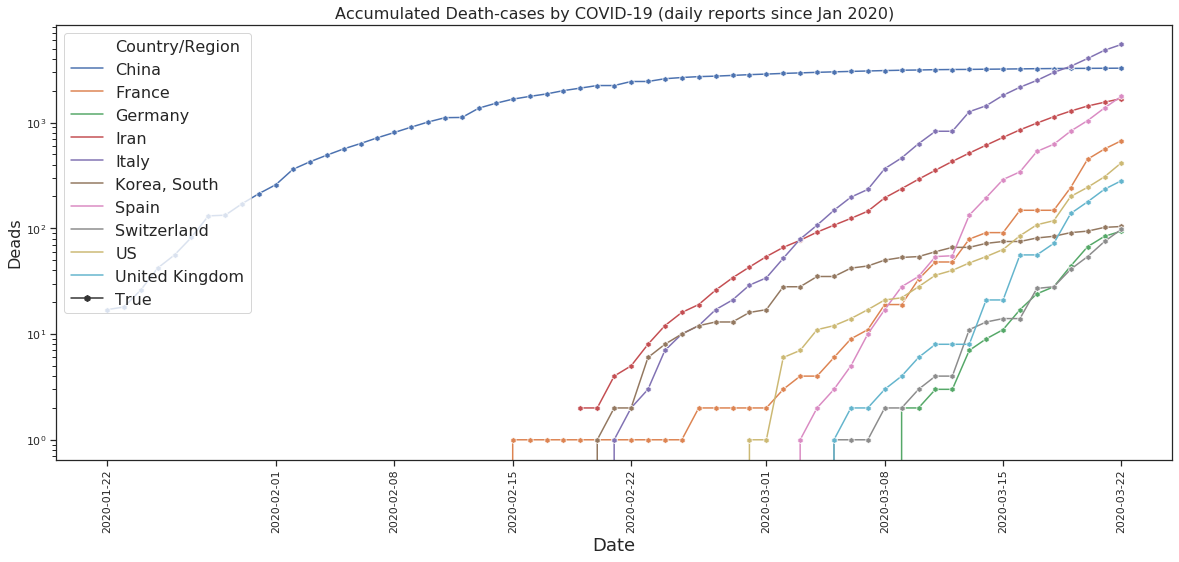

In [28]:
df = data_frames.loc[data_frames['Date']>'2020-01-15']
df = df.dropna()
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})


plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)

plt.title('Accumulated Death-cases by COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.lineplot(x='Date', y='#dead', hue='Country/Region', style=True, markers=marker_pool, data=df)
plot.set_yscale('log')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Deads', fontsize=16)
plot.legend(loc=2, prop={'size': 16})
display(plot)

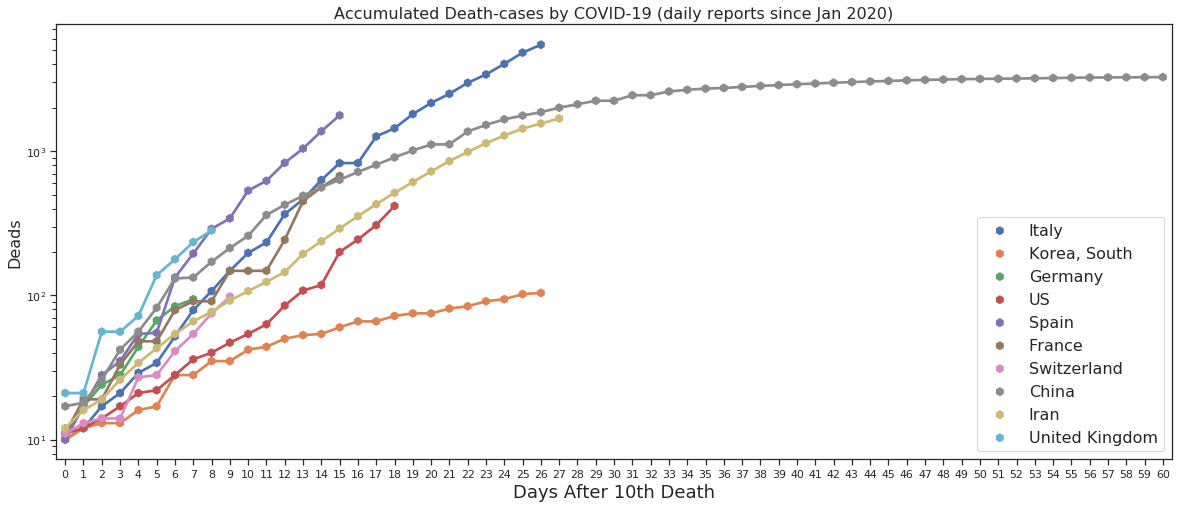

In [29]:
df = data_frames_indexed
df = df.dropna()
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)

plt.title('Accumulated Death-cases by COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='#dead', hue='Country/Region', style=True, markers=marker_pool, data=df)
plot.set_yscale('log')

plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('Deads', fontsize=16)
plot.legend(loc=4, prop={'size': 16})
display(plot)

## Accumulated Recovered Cases by Country

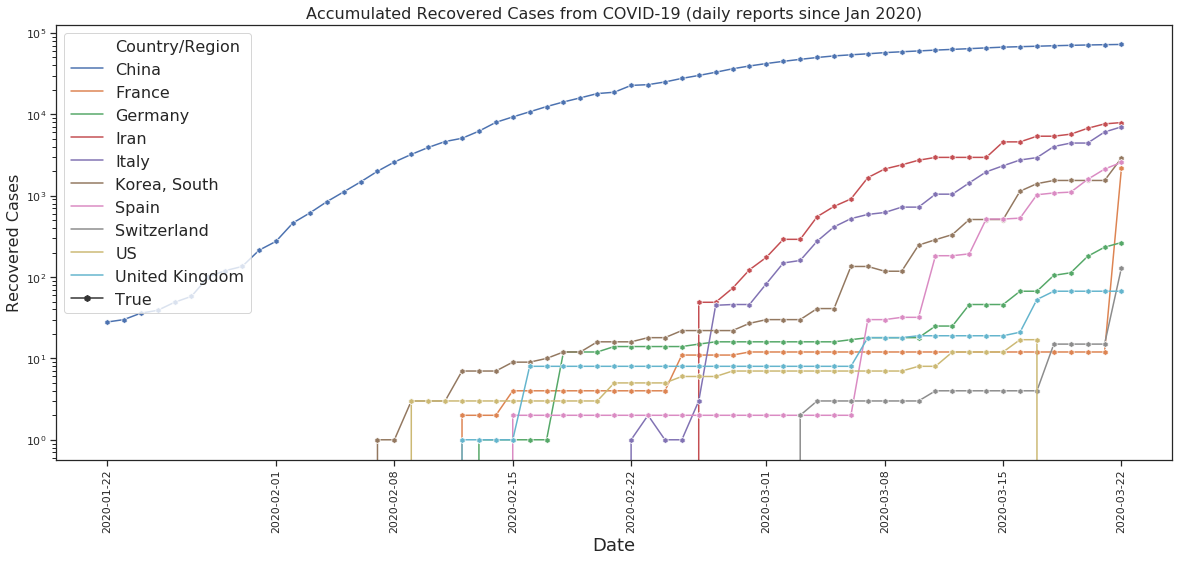

In [30]:
df = data_frames.loc[data_frames['Date']>'2020-01-15']
df = df.dropna()
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)

plt.title('Accumulated Recovered Cases from COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.lineplot(x='Date', y='#recovered', hue='Country/Region', style=True, markers=marker_pool, data=df)
plot.set_yscale('log')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Recovered Cases', fontsize=16)
plot.legend(loc=2, prop={'size': 16})

display(plot)

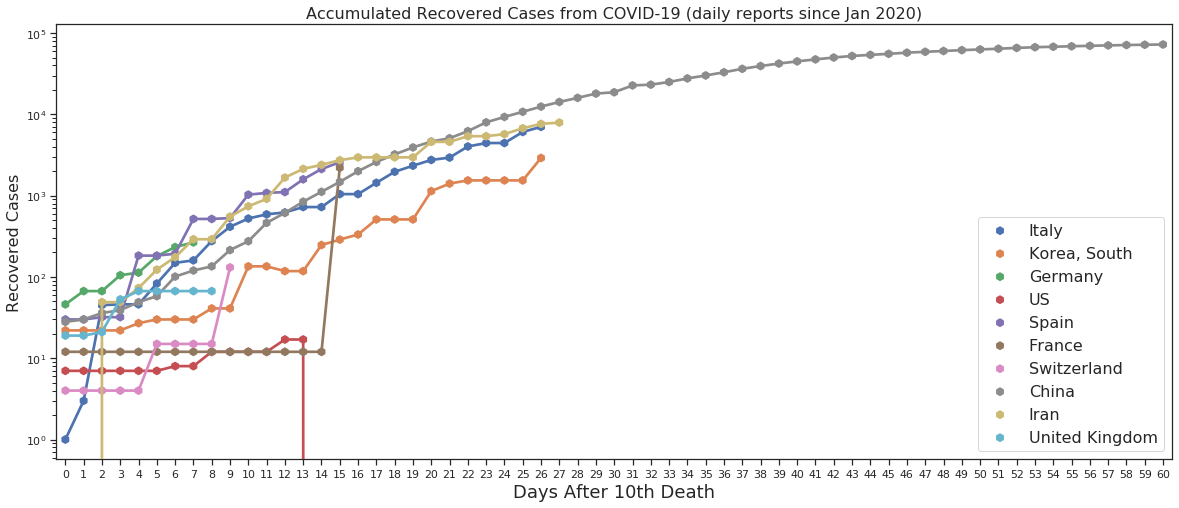

In [31]:
df = data_frames_indexed
df = df.dropna()
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

plt.figure(figsize=(20, 8))
plt.xticks(rotation=0)

plt.title('Accumulated Recovered Cases from COVID-19 (daily reports since Jan 2020)', fontsize=16)
plot = sns.pointplot(x='days_after_threshold', y='#recovered', hue='Country/Region', style=True, markers=marker_pool, data=df)
plot.set_yscale('log')
plt.xlabel(threshold_str, fontsize=18)
plt.ylabel('Recovered Cases', fontsize=16)
plot.legend(loc=4, prop={'size': 16})

display(plot)